In [21]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
# Download necessary resources
# nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\udgir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\udgir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
# ========== STEP 1: Load and Label Data ==========
def load_and_label_data(filepath, label):
    df = pd.read_csv(filepath)
    df['label'] = label
    return df

# Combine all datasets
dataframes = [
    load_and_label_data("dataset/preprocessed_spam.csv", "spam"),
    load_and_label_data("dataset/preprocessed_promotions.csv", "promotions"),
    load_and_label_data("dataset/preprocessed_updates.csv", "updates"),
    load_and_label_data("dataset/preprocessed_social.csv", "social"),
]

df = pd.concat(dataframes, ignore_index=True)

In [25]:
# ========== STEP 2: Preprocessing ==========
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # remove non-alphabetic chars
    tokens = text.split()
    lemmatizer = WordNetLemmatizer()
    cleaned = [lemmatizer.lemmatize(w) for w in tokens if w not in stopwords.words('english')]
    return " ".join(cleaned)

# Combine subject and body
df['text'] = df['Subject'].astype(str) + " " + df['Body'].astype(str)
df['text'] = df['text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_encoded'])

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=200)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# ========== STEP 3: Build CNN Model (No LSTM) ==========
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))  # Optional second Conv1D layer
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 categories

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\udgir\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
# ========== STEP 4: Train Model ==========
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5385 - loss: 1.0757 - val_accuracy: 0.9525 - val_loss: 0.1735
Epoch 2/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9324 - loss: 0.2039 - val_accuracy: 0.9559 - val_loss: 0.1793
Epoch 3/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9744 - loss: 0.1024 - val_accuracy: 0.9593 - val_loss: 0.1865
Epoch 4/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9844 - loss: 0.0569 - val_accuracy: 0.9542 - val_loss: 0.2042
Epoch 5/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9866 - loss: 0.0456 - val_accuracy: 0.9576 - val_loss: 0.2262


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9302 - loss: 0.2456
Test Accuracy: 0.95
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


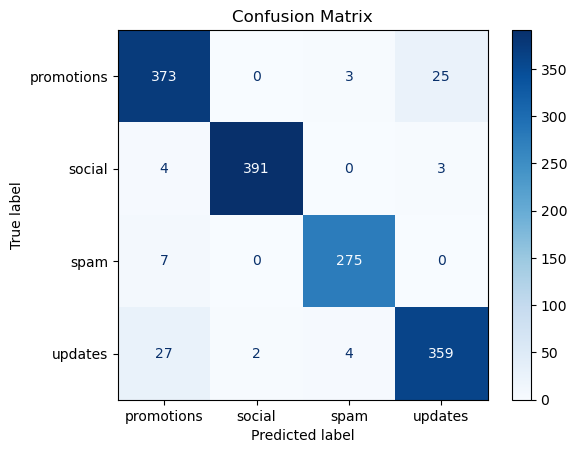

In [31]:
# ========== STEP 5: Evaluate ==========
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()